In [1]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
from mhcflurry import dataset
from mhcflurry.dataset import Dataset
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

Using Theano backend.


In [2]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq, max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))
y[y<0]=0


In [3]:
max_len

26

In [4]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25
embedding_dropout = 0.25
n_epochs = 100
epoch = 0


train_lstm01111_aucs = np.zeros((folds,n_epochs))
test_lstm01111_aucs = np.zeros((folds,n_epochs))


train_lstm011_aucs = np.zeros((folds,n_epochs))
test_lstm011_aucs = np.zeros((folds,n_epochs))


for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32,mask_zero = True)(sequence)
    forwards = LSTM(hidden, return_sequences=True, dropout_W = 0.5, dropout_U = 0.5)(embedded)
    backwards = LSTM(hidden, return_sequences=True, dropout_W = 0.5,dropout_U = 0.5, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    forwards2 = LSTM(hidden, dropout_W = 0.5, dropout_U = 0.5)(merged)
    backwards2 = LSTM(hidden, dropout_W = 0.5,dropout_U = 0.5, go_backwards=True)(merged)

    merged2 = merge([forwards2, backwards2], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged2)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm01111 = Model(input = sequence, output = output)
    
    lstm01111.compile(optimizer = 'adam', loss='mean_squared_error')
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32,mask_zero = True)(sequence)
    forwards = LSTM(hidden, dropout_W = 0.5, dropout_U = 0.5)(embedded)
    backwards = LSTM(hidden, dropout_W = 0.5,dropout_U = 0.5, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm011 = Model(input = sequence, output = output)
    
    lstm011.compile(optimizer = 'adam', loss='mean_squared_error')
    
    for epoch in range(n_epochs):
        
        
        #lstm011ss
        lstm01111.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        train_lstm01111_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm01111.predict(X[train_idx]))
        test_lstm01111_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm01111.predict(X[test_idx]))
        
        train_lstm01111_aucs[i][epoch]=train_lstm01111_auc
        test_lstm01111_aucs[i][epoch]=test_lstm01111_auc
        
        #lstm011 
        lstm011.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        train_lstm011_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm011.predict(X[train_idx]))
        test_lstm011_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm011.predict(X[test_idx]))
        
        train_lstm011_aucs[i][epoch]=train_lstm011_auc
        test_lstm011_aucs[i][epoch]=test_lstm011_auc
        
        print(test_lstm01111_auc, test_lstm011_auc, epoch, i)


train_lstm01111_aucs_mean = np.mean(train_lstm01111_aucs, axis=0)
test_lstm01111_aucs_mean = np.mean(test_lstm01111_aucs, axis=0)


train_lstm011_aucs_mean = np.mean(train_lstm011_aucs, axis=0)
test_lstm011_aucs_mean = np.mean(test_lstm011_aucs, axis=0)

Epoch 1/1
6376/6376 [==============================] - 24s - loss: 0.0740    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0710    
0.805699329752 0.850989091349 0 0
Epoch 1/1
6376/6376 [==============================] - 24s - loss: 0.0650    
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0570    
0.81440392078 0.863921207193 1 0
Epoch 1/1
6376/6376 [==============================] - 24s - loss: 0.0628    
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0541    
0.831093836461 0.878826078989 2 0
Epoch 1/1
6376/6376 [==============================] - 25s - loss: 0.0603    
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0503    
0.845854143277 0.894817634614 3 0
Epoch 1/1
6376/6376 [==============================] - 25s - loss: 0.0574    
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0455    
0.861327489053 0.913797459571 4 0
Epoch 1/1
6376/6376 [==============================

KeyboardInterrupt: 

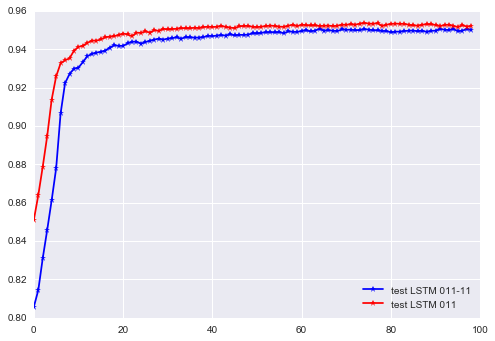

In [5]:
plt.plot( np.arange(0,99,1), test_lstm01111_aucs[0,0:99],color='b',marker='*', linestyle='-', label ="test LSTM 011-11")
plt.plot( np.arange(0,99,1), test_lstm011_aucs[0,0:99],color='r',marker='*', linestyle='-', label ="test LSTM 011")
plt.legend(loc=4)

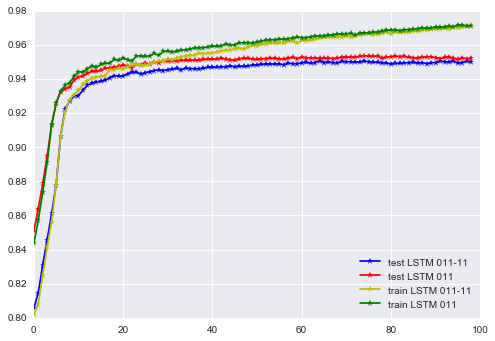

In [6]:
plt.plot( np.arange(0,99,1), test_lstm01111_aucs[0,0:99],color='b',marker='*', linestyle='-', label ="test LSTM 011-11")
plt.plot( np.arange(0,99,1), test_lstm011_aucs[0,0:99],color='r',marker='*', linestyle='-', label ="test LSTM 011")
plt.plot( np.arange(0,99,1), train_lstm01111_aucs[0,0:99],color='y',marker='*', linestyle='-', label ="train LSTM 011-11")
plt.plot( np.arange(0,99,1), train_lstm011_aucs[0,0:99],color='g',marker='*', linestyle='-', label ="train LSTM 011")
plt.legend(loc=4)